# Email Extraction Example

This example shows how you can use Experiments to compare the performance of two different models on the same use case. The use case here is an email extraction example. We use a langchain agent to extract the important elements of some example emails, then compare performance against a baseline.

In [ ]:
!pip install arize-phoenix langchain langchain-core langchain-community langchain-benchmarks langchain-openai nest_asyncio jarowinkler

# Set Up OpenAI API Key

In [9]:
import os
from getpass import getpass

if not os.getenv("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass("🔑 Enter your OpenAI API key: ")

# Import Modules

In [10]:
import json
import tempfile
from datetime import datetime, timezone

import jarowinkler
import nest_asyncio
import pandas as pd
import phoenix as px
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_benchmarks import download_public_dataset, registry
from langchain_openai.chat_models import ChatOpenAI
from openinference.instrumentation.langchain import LangChainInstrumentor
from openinference.instrumentation.openai import OpenAIInstrumentor
from opentelemetry.exporter.otlp.proto.grpc.trace_exporter import OTLPSpanExporter
from opentelemetry.sdk.trace import TracerProvider
from opentelemetry.sdk.trace.export import SimpleSpanProcessor
from phoenix.experiments import evaluate_experiment, run_experiment
from phoenix.experiments.types import Example

nest_asyncio.apply()

# Launch Phoenix

First we have to set up our instance of Phoenix and our instrumentors to capture traces from our agent. We'll use both our Langchain and OpenAI auto instrumentors because while our task uses Langchain, our evaluation function will call OpenAI directly.

In [ ]:
px.launch_app()

# Instrument LangChain and OpenAI

In [12]:
endpoint = "http://127.0.0.1:4317"
(tracer_provider := TracerProvider()).add_span_processor(
    SimpleSpanProcessor(OTLPSpanExporter(endpoint))
)

LangChainInstrumentor().instrument(tracer_provider=tracer_provider)
OpenAIInstrumentor().instrument(tracer_provider=tracer_provider)

# Experiments in Phoenix

Experiments in Phoenix are made up of 3 elements: a dataset, a task, and an evaluation. The dataset is a list of the inputs and expected outputs that we'll use to evaluate. The task is an operation that should be performed on each input. Finally, the evaluation defines how the result of that task should be compared against the expected output.

For this example, here's what each looks like:
*   Dataset - a dataframe of emails to analyze, and the expected output for our agent
*   Task - a langchain agent that extracts key info from our input emails. The result of this task will then be compared against the expected output
*   Eval - jarowinkler distance calculation on the task's output and expected output



# Download JSON Data

We've prepared some example emails and correct responses that we can use to evaluate our two models. Let's download those and save them to a temporary file.

In [ ]:
dataset_name = "Email Extraction"

with tempfile.NamedTemporaryFile(suffix=".json") as f:
    download_public_dataset(registry[dataset_name].dataset_id, path=f.name)
    df = pd.read_json(f.name)[["inputs", "outputs"]]
df = df.sample(10, random_state=42)
df

# Upload Dataset to Phoenix

Next, we'll upload our dataset to Phoenix. Once this is present in Phoenix, we can run multiple experiments with different models on this one dataset, and compare their performance.

In [ ]:
dataset = px.Client().upload_dataset(
    dataset_name=f"{dataset_name}{datetime.now(timezone.utc)}",
    inputs=df.inputs,
    outputs=df.outputs.map(lambda obj: obj["output"]),
)

# Set Up LangChain

Now we'll set up our Langchain agent. This is a straightforward agent that makes a call to our specified model and formats the response as JSON.

In [15]:
model = "gpt-4o"

llm = ChatOpenAI(model=model).bind_functions(
    functions=[registry[dataset_name].schema],
    function_call=registry[dataset_name].schema.schema()["title"],
)
output_parser = JsonOutputFunctionsParser()
extraction_chain = registry[dataset_name].instructions | llm | output_parser

# Define Task Function

Next, we need to define a Task for our experiment to use

In [16]:
def task(ex: Example) -> str:
    return extraction_chain.invoke(ex.input)

# Check that the task is working by running it on at least one Example

In [ ]:
first_key = next(iter(dataset.examples))
first_example = dataset.examples[first_key]

task(first_example)

# Run Experiment

Now we're ready to run our experiment. We'll specify our dataset and task, and generate responses for us to evaluate in the next step.

In [ ]:
experiment = run_experiment(dataset, task)

# Define Evaluator

Finally, we need to define our evaluation function. Here we'll use a jarowinkler similarity function that generates a score for how similar the output and expected text are.

In [33]:
def jarowinkler_similarity(output, expected) -> float:
    return jarowinkler.jarowinkler_similarity(
        json.dumps(output, sort_keys=True),
        json.dumps(expected, sort_keys=True),
    )

# Evaluate Experiment

In [ ]:
evaluate_experiment(experiment, jarowinkler_similarity)

Now we have scores on how well GPT-4o does at extracting email facts. This is helpful, but doesn't mean much on its own. Let's compare it against another model.

# Re-run with GPT 3.5 Turbo and Compare Results

To compare results with another model, we simply need to redefine our task. Our dataset and evaluator can stay the same.

In [35]:
model = "gpt-3.5-turbo"

llm = ChatOpenAI(model=model).bind_functions(
    functions=[registry[dataset_name].schema],
    function_call=registry[dataset_name].schema.schema()["title"],
)
extraction_chain = registry[dataset_name].instructions | llm | output_parser

In [ ]:
def task(ex: Example) -> str:
    return extraction_chain.invoke(ex.input)

In [ ]:
experiment = run_experiment(dataset, task)

In [ ]:
evaluate_experiment(experiment, jarowinkler_similarity)

# View results

Now if you check your Phoenix experiment, you can compare jarowinkler scores on a per query basis, and view aggregate model performance results.

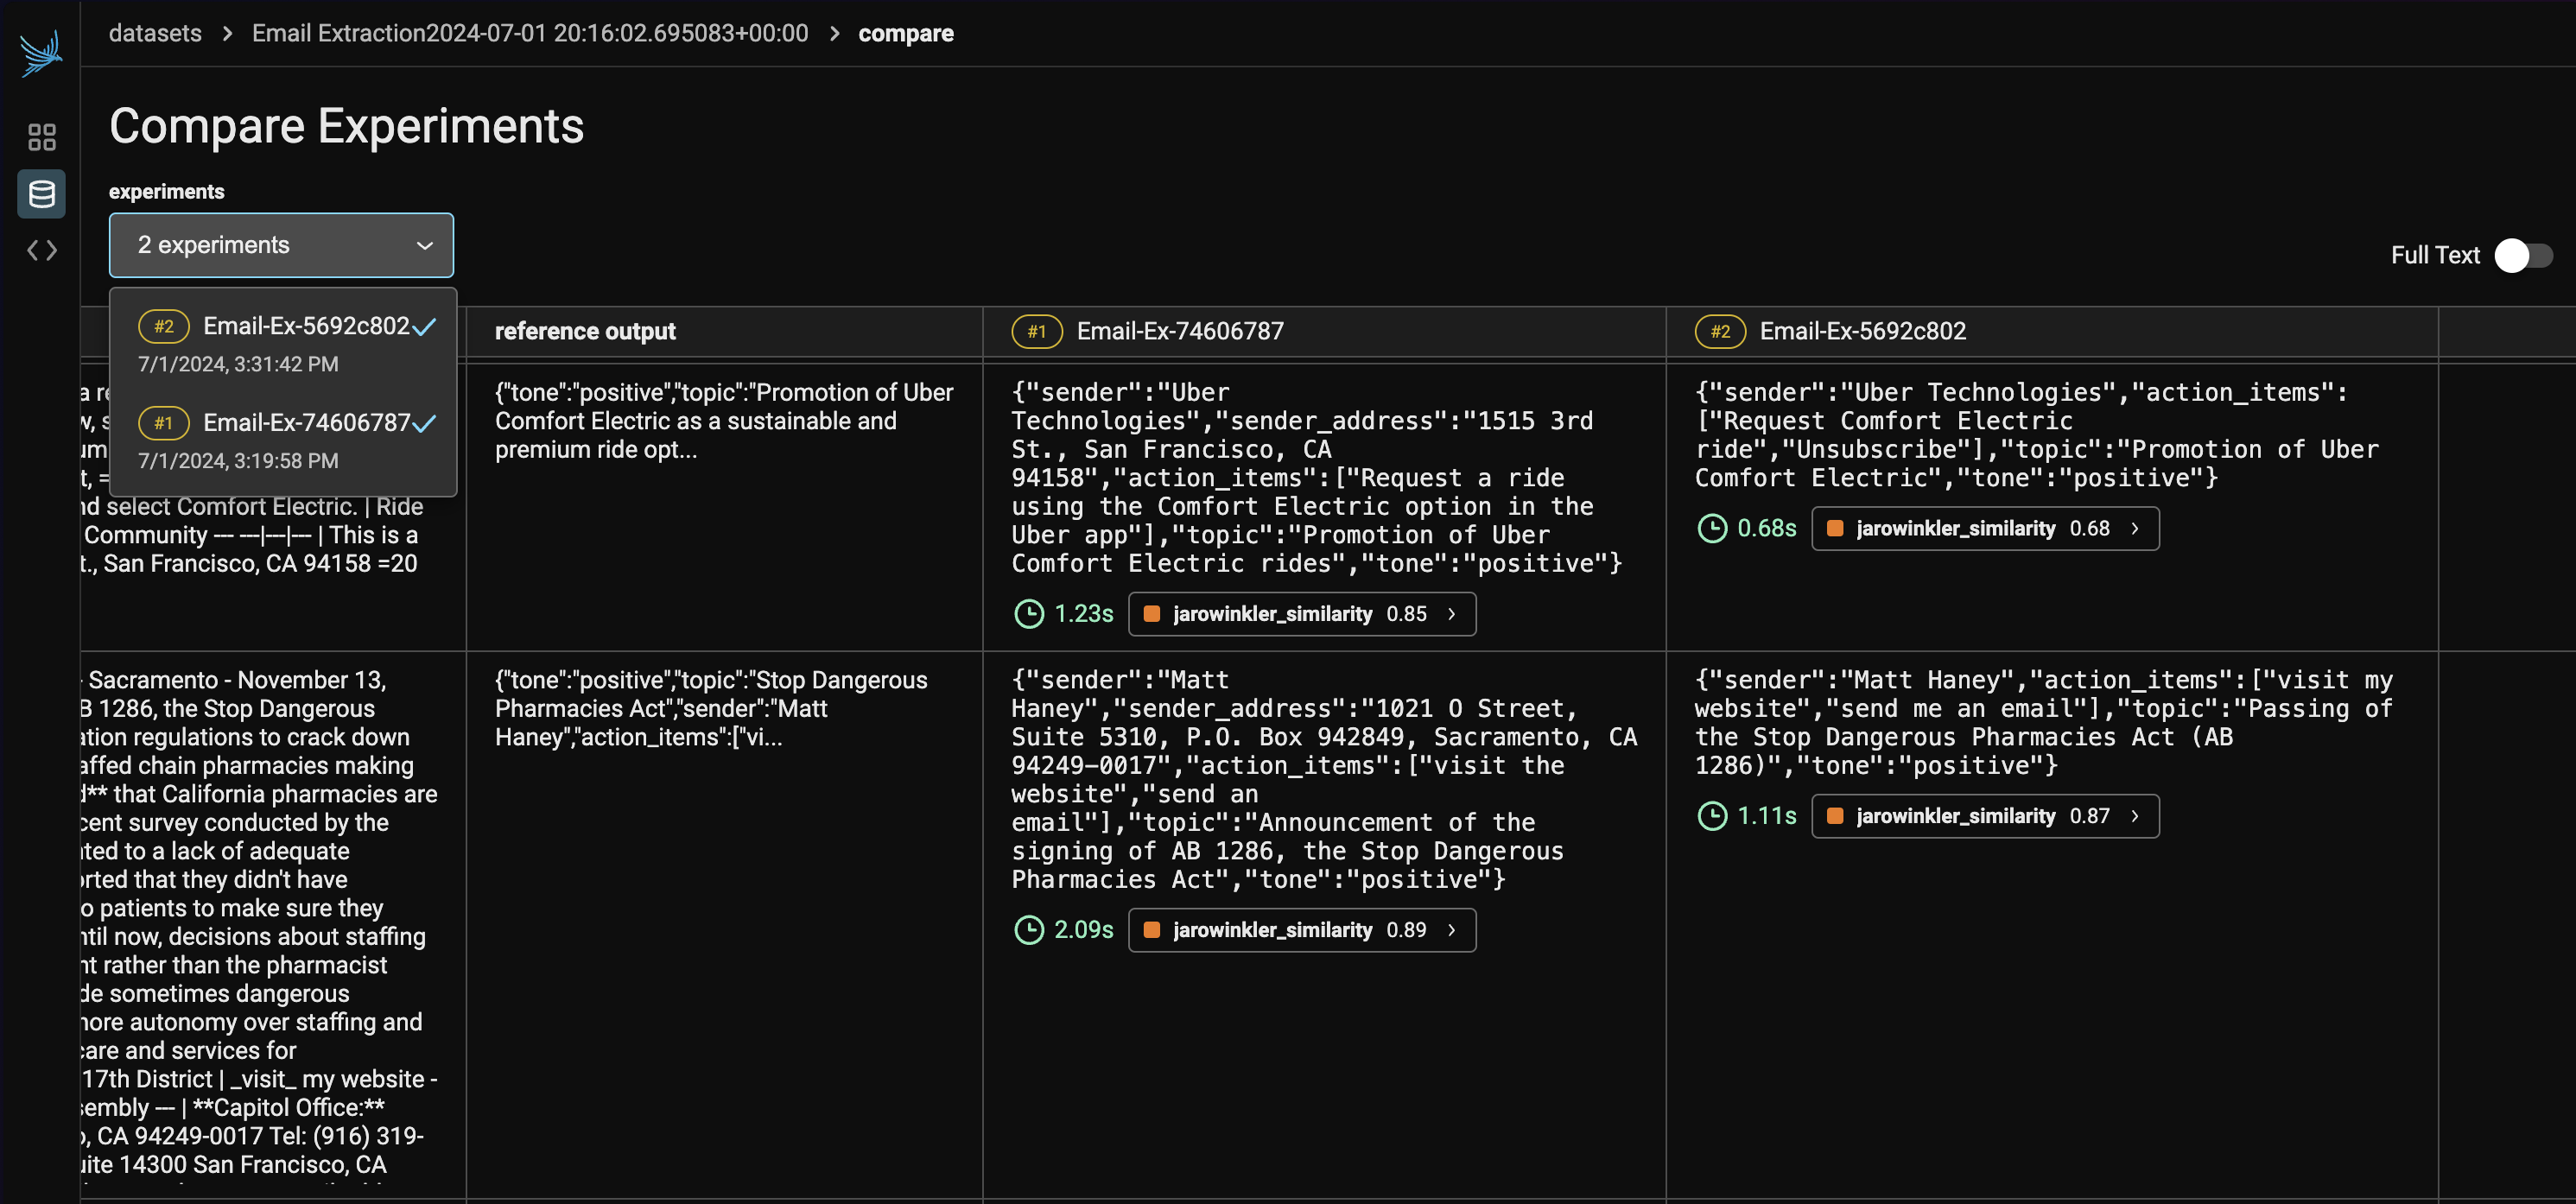